Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
img:  <class 'numpy.ndarray'> (213, 320, 3)


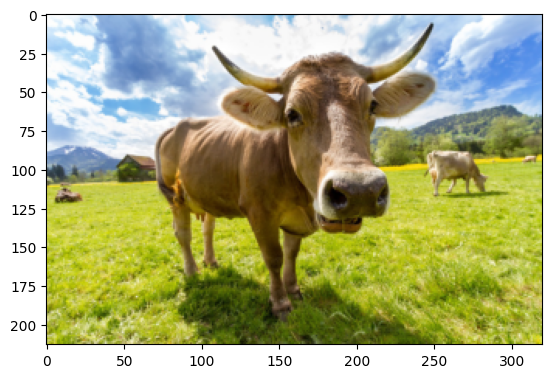

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


from pathlib import Path # ファイルシステム
from google.colab import drive # Google drive
drive.mount('/content/drive')
p = Path('/content/drive/My Drive/iicex/')  # 画像ファイルのフォルダ
#list( p.iterdir() )  # フォルダの内容をリストにする


from skimage import io #入出力ライブラリ読込
img = io.imread('/content/drive/My Drive/iicex/cow.png')  # 画像ファイルの読み込み
#from PIL import Image #pillow読込
#PILimg = Image.open('/content/drive/My Drive/iicex/baboon.png')  # 画像ファイルの読み込み
#img = PILimg.convert('L') #グレイスケール変換
sampleimg = np.asarray(img) #numpy配列に変換
#print("PILimg: ", type(PILimg))
print("img: ", type(sampleimg), sampleimg.shape)

#plt.imshow(sampleimg, cmap='gray', vmin=0, vmax=255)
plt.imshow(sampleimg)

In [ ]:
colors3 = np.array([[255, 0, 0,], [0, 255, 0], [0, 0, 255]])
def closestin3(x):
  distances = np.zeros(3)

  for i in range(3):
    distances[i] = np.sum((x - colors3[i]) **2) #numpy配列の二乗(**2)は各要素ごと

  print("distances: ", distances)

  closestindex = np.argmin(distances) #最小値のインデックス取得
  return  colors3[closestindex]

print(closestin3([3,4,5]))



distances:  [63545. 63035. 62525.]
[  0   0 255]


In [ ]:
colors5 = np.array([[255, 0, 0,], [0, 255, 0], [0, 0, 255], [0, 0, 0], [255, 255, 255]])

def closestinN(x, N): #N色の中から選ぶ
  distances = np.zeros(N)

  for i in range(N):
    distances[i] = np.sum((x - colors5[i]) **2) #numpy配列の二乗(**2)は各要素ごと

  closestindex = np.argmin(distances) #最小値のインデックス取得
  return  colors5[closestindex]

print(closestinN([3,4,5], 4))


[0 0 0]


<function matplotlib.pyplot.show(close=None, block=None)>

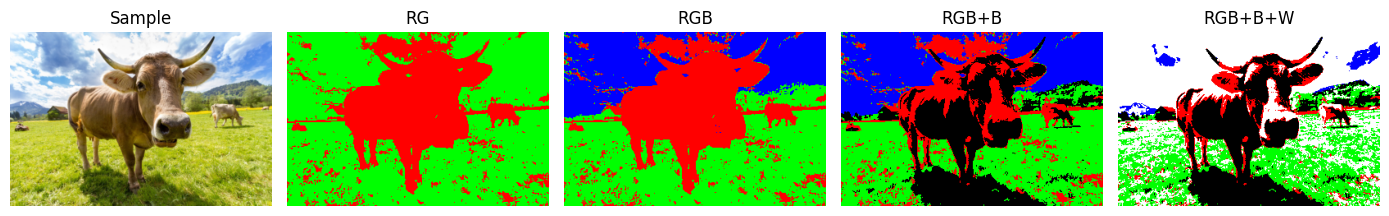

In [ ]:
def translate(sampleimg, N):

  #number of row, column
  row = sampleimg.shape[0]
  column = sampleimg.shape[1]
  Timg = np.array([[[0, 0, 0] for j in range(column)] for i in range (row)]) #三色あるので宣言注意


  for i in range(row):
    for j in range(column):
      #print("i, j, n: ", i, j, n)
      #print(sampleimg[ i-n : i+n+1, j-n : j+n+1])
      Timg[i, j, :] = closestinN(sampleimg[i, j, :], N)

  return Timg


# squeeze = Falseとすると分割数1,1でも二次元配列として作成されるのでfor文などでエラーしにくくなる
#plt.subplotsを使うと同時に宣言できる。axesは二次元配列(nd.array)で出てくる
fig, axes = plt.subplots(1, 5, figsize=(14,3), tight_layout=True, squeeze = False)
titles = ["Sample", "RG", "RGB", "RGB+B", "RGB+B+W"]
imgs = [sampleimg, translate(sampleimg, 2), translate(sampleimg, 3), translate(sampleimg, 4), translate(sampleimg, 5)]
#axes[1,3].set_visible(False) #軸を消す
for row in axes:
  for one in row:
    one.axis("off") #軸を消す



for i in range(1):
  for j in range(5):
    #if (i == 1) and (j == 3):continue
    #fig.add_subplot()は必要なくなり、配列的に処理ができるようになる。
    axes[i, j].imshow(imgs[4*i + j], cmap='gray', vmin=0, vmax=255) #このimgsの指定の仕方注意!
    axes[i, j].set_title(titles[4*i + j])




plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

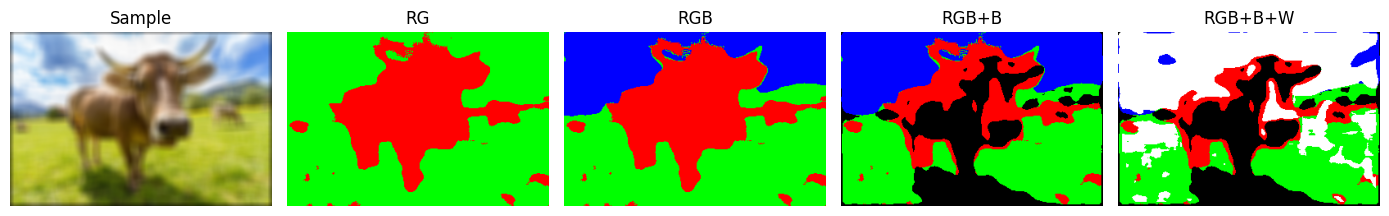

In [ ]:
#外枠をすべてゼロで追加する関数 #1色ver
#https://www.higashisalary.com/entry/opencv-add-frame

def sotowaku (img, num_insert): #num_insertは縁の幅ピクセル
  #枠追加処理(上下)
  bk1=np.zeros((num_insert,img.shape[1]),np.uint8)
  array=np.insert(img, 0, bk1, axis=0)
  array=np.insert(array, array.shape[0], bk1, axis=0)
  #枠追加処理(左右)
  bk2=np.zeros((array.shape[0],num_insert),np.uint8)
  array=np.insert(array, [0], bk2, axis=1)
  array=np.insert(array, [array.shape[1]], bk2, axis=1)
  return array




#Smoothing filter 3色バージョン
def Sfilter(sampleimg, filterN):

  #number of row, column
  row = sampleimg.shape[0]
  column = sampleimg.shape[1]
  Simg = np.array([[[0, 0, 0] for j in range(column)] for i in range(row)])


  n = filterN//2 #フィルタのサイズ//2
  for k in range(3): #各色ごとにやってみる。もっときれいな書き方がある？
    x = Simg[:, :, k]
    #print("Simg[:, :, k]", Simg[:, :, k].shape)

    sotoimg = sotowaku(sampleimg[:, :, k], n)

    for i in range(row):
      for j in range(column):
        #print("Simg[i, j, k]", Simg[i, j, k])
        #print("i, j, n: ", i, j, n)
        #print(sampleimg[ i-n : i+n+1, j-n : j+n+1])
        #print("sotoimg[ i : i+(2*n)+1, j : j+(2*n)+1, k]: ", sotoimg[ i : i+(2*n)+1, j : j+(2*n)+1, k].shape)
        x[i, j] = np.sum(sotoimg[ i : i+(2*n)+1, j : j+(2*n)+1] * np.full( (filterN, filterN), 1/filterN**2 ) ) #np.fullメソッド
        #平均とるので1/N**2になる！

  return Simg

#plt.imshow(Sfilter(sampleimg, 3))



fig, axes = plt.subplots(1, 5, figsize=(14,3), tight_layout=True, squeeze = False)
titles = ["Sample", "RG", "RGB", "RGB+B", "RGB+B+W"]
Ssampleimg = Sfilter(sampleimg, 11)
imgs = [Ssampleimg, translate(Ssampleimg, 2), translate(Ssampleimg, 3), translate(Ssampleimg, 4), translate(Ssampleimg, 5)]
#axes[1,3].set_visible(False) #軸を消す
for row in axes:
  for one in row:
    one.axis("off") #軸を消す



for i in range(1):
  for j in range(5):
    #if (i == 1) and (j == 3):continue
    #fig.add_subplot()は必要なくなり、配列的に処理ができるようになる。
    axes[i, j].imshow(imgs[4*i + j], cmap='gray', vmin=0, vmax=255) #このimgsの指定の仕方注意!
    axes[i, j].set_title(titles[4*i + j])


plt.show